In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                        roc_curve, auc, roc_auc_score, log_loss)
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score

In [2]:
# files = [
#     'three_1s_no.csv',
#     'three_1s_0.5.csv',
#     'three_1s_0.8.csv',
#     'three_2s_no.csv',
#     'three_2s_0.5.csv',
#     'three_2s_0.8.csv',
#     'three_3s_no.csv',
#     'three_3s_0.5.csv',
#     'three_3s_0.8.csv',
#     'three_4s_no.csv',
#     'three_4s_0.5.csv',
#     'three_4s_0.8.csv',
#     'three_5s_no.csv',
#     'three_5s_0.5.csv',
#     'three_5s_0.8.csv'
# ]

# base_path = '/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/overfit_analysis/feature_extracted_data'


files = [
    'three_class_pp_1s_no.csv',
    'three_class_pp_1s_0.5.csv',
    'three_class_pp_1s_0.8.csv',
    'three_class_pp_2s_no.csv',
    'three_class_pp_2s_0.5.csv',
    'three_class_pp_2s_0.8.csv',
    'three_class_pp_3s_no.csv',
    'three_class_pp_3s_0.5.csv',
    'three_class_pp_3s_0.8.csv',
    'three_class_pp_4s_no.csv',
    'three_class_pp_4s_0.5.csv',
    'three_class_pp_4s_0.8.csv',
    'three_class_pp_5s_no.csv',
    'three_class_pp_5s_0.5.csv',
    'three_class_pp_5s_0.8.csv'
]

base_path = '/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/pipeline/modified/data_extracted_features'

In [3]:
data_path = os.path.join(base_path, files[5])
features = pd.read_csv(data_path)
features.drop(columns=['center_time', 'start_time', 'end_time'], inplace=True)
details = files[0].split('_')
exp_name = f"{details[1]}_{details[-1].replace('.csv', '')}"
print(f"Nested cross-validation for {exp_name}")

X = features.drop(columns=['label', 'experiment_id'])
y = features['label']
groups = features['experiment_id']

Nested cross-validation for class_no


In [4]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [5]:
splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [6]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [7]:
y_pred = model.predict(X_test)
classes_ordered = ['pre-void','void', 'post-void']  # Display order you want
labels_ordered = [1, 2, 0]

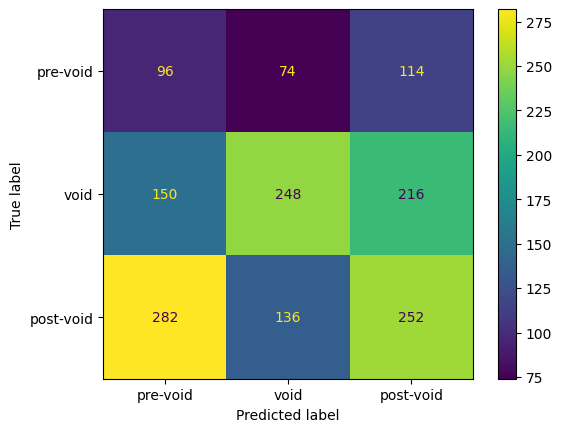

Classification Report:
              precision    recall  f1-score   support

    pre-void       0.18      0.34      0.24       284
        void       0.54      0.40      0.46       614
   post-void       0.43      0.38      0.40       670

    accuracy                           0.38      1568
   macro avg       0.39      0.37      0.37      1568
weighted avg       0.43      0.38      0.40      1568



In [8]:
# Confusion matrix with void on top
cm = confusion_matrix(y_test, y_pred, labels=labels_ordered)  # [1, 0] order
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                    display_labels=classes_ordered)  # ['void', 'non-void']
cm_display.plot()
plt.show()
    
# Classification report with void first
report = classification_report(y_test, y_pred, 
                                labels=labels_ordered,  # [1, 0]
                                target_names=classes_ordered)  # ['void', 'non-void']
print("Classification Report:")
print(report)

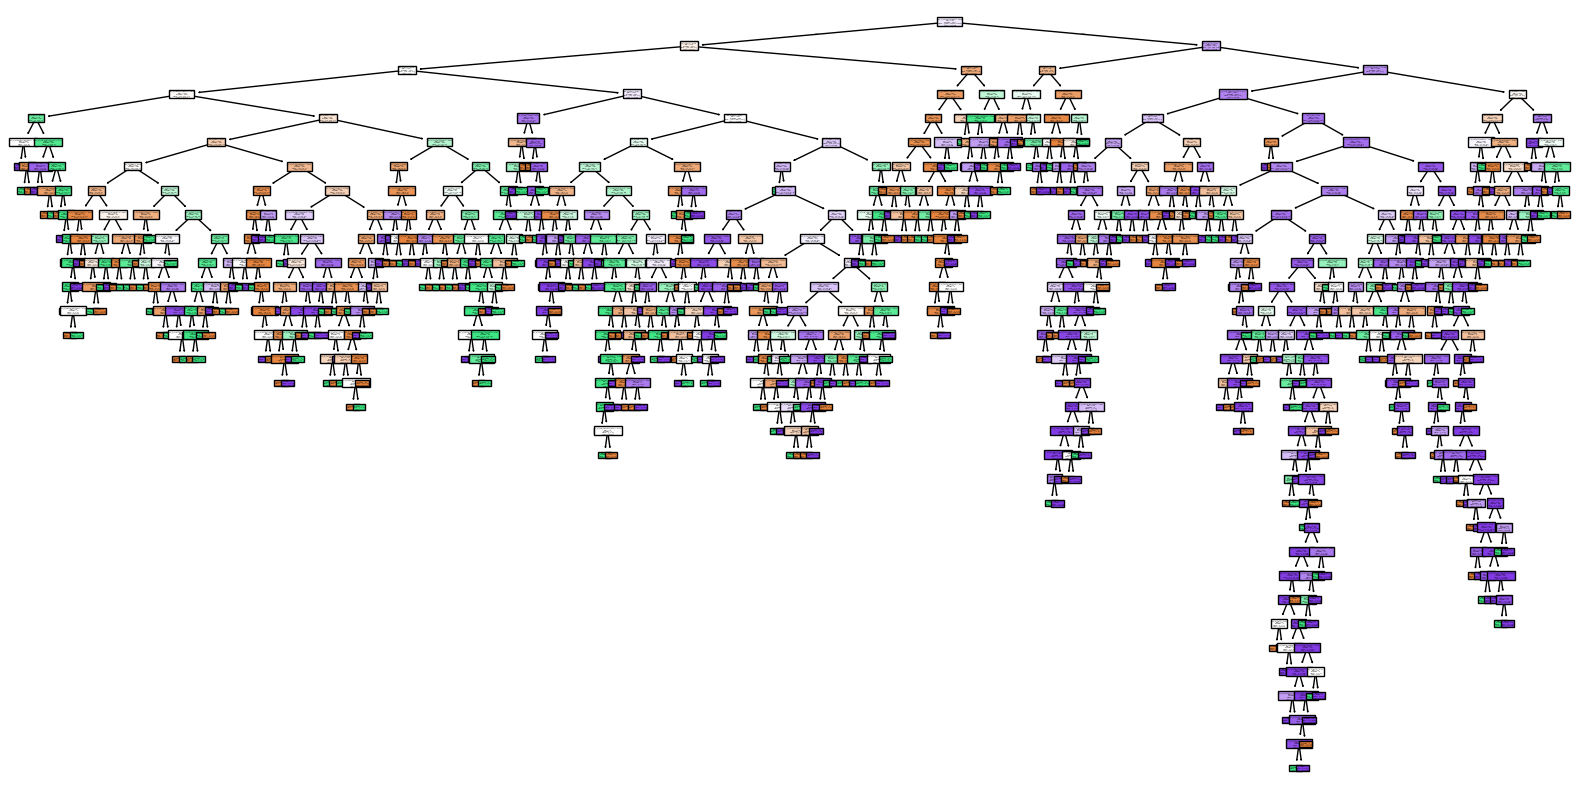

In [9]:
# View decision tree
from sklearn.tree import plot_tree
plt.figure(figsize=(20,10))
plot_tree(model, filled=True, feature_names=X.columns, class_names=classes_ordered)
plt.show()

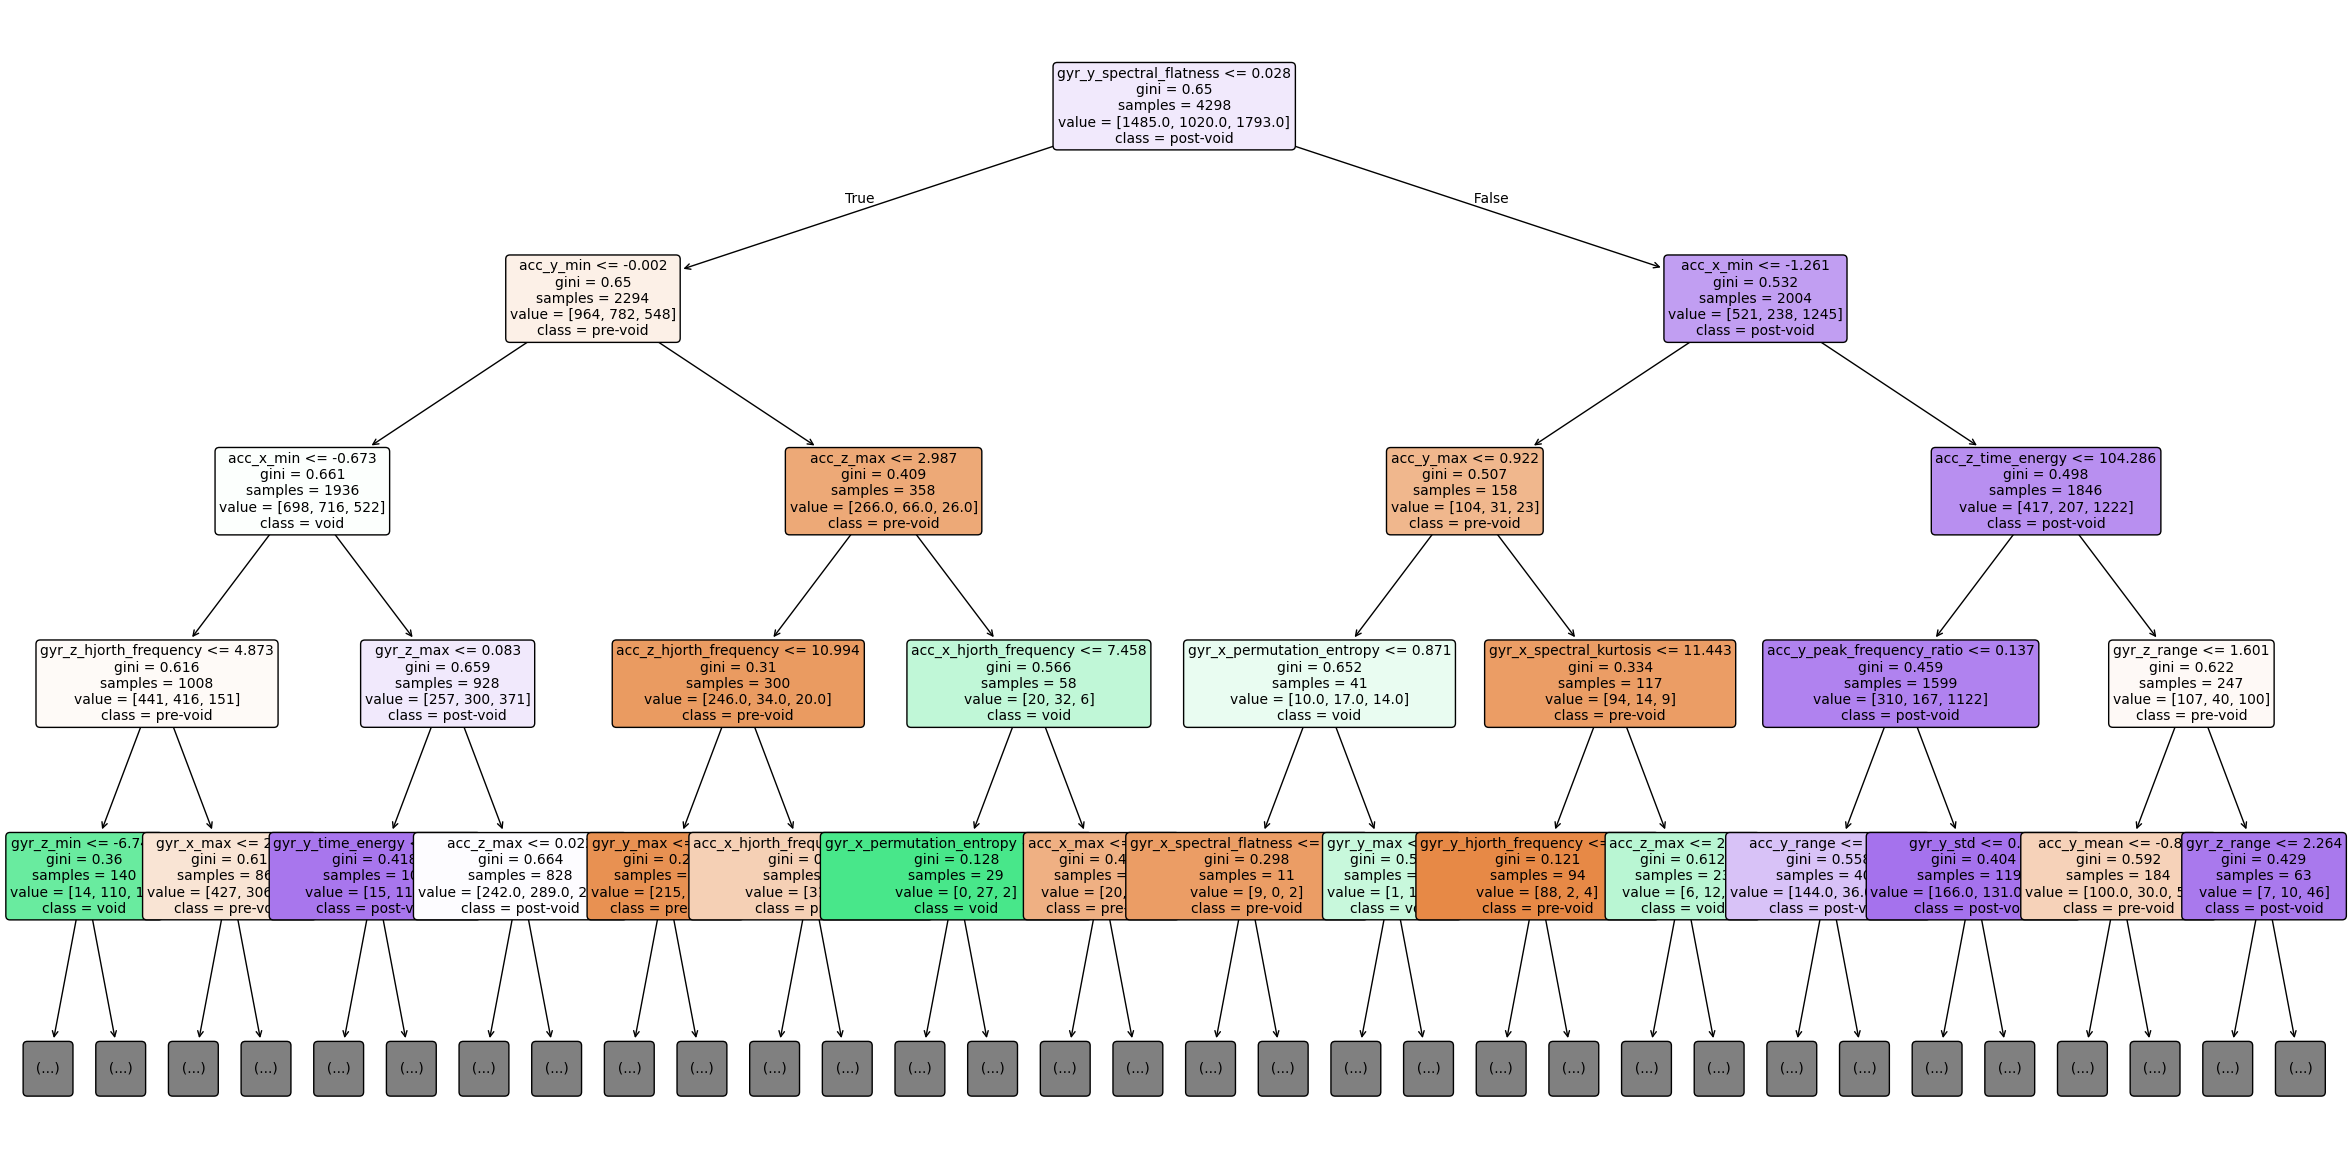

In [10]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 15))  # enlarge figure
plot_tree(
    model,
    filled=True,
    feature_names=X.columns,
    class_names=classes_ordered,
    rounded=True,
    fontsize=10,        # smaller font to fit more
    max_depth=4         # change depth to see more/less
)
plt.show()

In [11]:
import plotly.graph_objects as go
import networkx as nx
from sklearn.tree import _tree

def add_nodes_edges(tree, feature_names, parent=None, node_id=0, depth=0, G=None, pos=None, x=0, y=0, dx=1.0):
    """Recursively add nodes/edges for plotly tree"""
    if G is None:
        G = nx.DiGraph()
        pos = {}
    
    # Node label
    if tree.feature[node_id] != _tree.TREE_UNDEFINED:
        name = f"{feature_names[tree.feature[node_id]]} <= {tree.threshold[node_id]:.2f}"
    else:
        # Leaf node
        values = tree.value[node_id][0]
        name = f"Leaf: class={values.argmax()}, counts={values}"
    
    G.add_node(node_id, label=name, depth=depth)
    pos[node_id] = (x, y)
    
    if parent is not None:
        G.add_edge(parent, node_id)
    
    if tree.feature[node_id] != _tree.TREE_UNDEFINED:
        # Left child
        add_nodes_edges(tree, feature_names, node_id, tree.children_left[node_id], depth+1, G, pos, x-dx, y-1, dx/2)
        # Right child
        add_nodes_edges(tree, feature_names, node_id, tree.children_right[node_id], depth+1, G, pos, x+dx, y-1, dx/2)
    
    return G, pos

# Build graph from sklearn DecisionTreeClassifier
tree = model.tree_
G, pos = add_nodes_edges(tree, list(X.columns))

# Create edge traces
edge_x, edge_y = [], []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(x=edge_x, y=edge_y,
                        line=dict(width=1, color='#888'),
                        hoverinfo='none',
                        mode='lines')

# Create node traces
node_x, node_y, labels = [], [], []
for node, data in G.nodes(data=True):
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    labels.append(data['label'])

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=labels,
    textposition="top center",
    hoverinfo="text",
    marker=dict(
        showscale=False,
        color="lightblue",
        size=30,
        line_width=2))

# Final figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="Interactive Decision Tree",
                    title_x=0.5,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
               )

fig.show()